In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import string
from tqdm.notebook import tqdm
from konlpy.tag import *
import json
import re
from sklearn.model_selection import train_test_split
import random
import nltk
import wget
import zipfile
import sklearn
import os

tqdm.pandas()
plt.style.use("dark_background")

C:\Users\82104\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [24]:
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_text.npy", filename="./Datasets/NLU Benchmark/train_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_label.npy", filename="./Datasets/NLU Benchmark/train_label.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_text.npy", filename="./Datasets/NLU Benchmark/test_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_label.npy", filename="./Datasets/NLU Benchmark/test_label.npy")

train_text = np.load("./Datasets/NLU Benchmark/train_text.npy", allow_pickle=True).tolist()
train_label = np.load("./Datasets/NLU Benchmark/train_label.npy", allow_pickle=True).tolist()
test_text = np.load("./Datasets/NLU Benchmark/test_text.npy", allow_pickle=True).tolist()
test_label = np.load("./Datasets/NLU Benchmark/test_label.npy", allow_pickle=True).tolist()

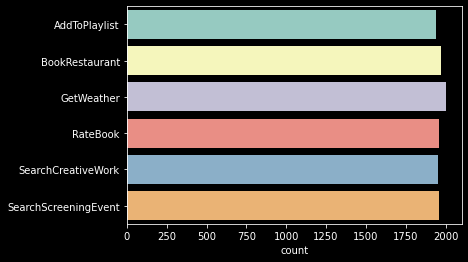

In [25]:
fig, ax = plt.subplots()
sb.countplot(ax=ax, y=train_label);

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
word2idx = tokenizer.word_index
cnts = sorted(tokenizer.word_counts.values(), reverse=True)
ratio = 0.99
for vocab_size, value in enumerate(np.cumsum(cnts)/np.sum(cnts)):
    if value >= ratio:
        break
print(f"{vocab_size:,}개의 단어로 전체 data의 {ratio:.0%}를 표현할 수 있습니다.")
print(f"{len(word2idx):,}개의 단어 중 {vocab_size/len(word2idx):.1%}에 해당합니다.")

In [104]:
tokenizer = Tokenizer(num_words=vocab_size + 2, oov_token="UNK")
tokenizer.fit_on_texts(train_text)
word2idx = tokenizer.word_index
word2cnt = dict(sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True))

X_tr = tokenizer.texts_to_sequences(train_text)
X_te = tokenizer.texts_to_sequences(test_text)

lens = sorted([len(doc) for doc in X_tr])
ratio = 0.99
max_len = int(np.quantile(lens, 0.99))
print(f"길이가 가장 긴 문장의 길이는 {np.max(lens)}이고 길이가 {max_len} 이하인 문장이 전체의 {ratio:.0%}를 차지합니다.")

X_tr = pad_sequences(X_tr, maxlen=max_len)
X_te = pad_sequences(X_te, maxlen=max_len)

길이가 가장 긴 문장의 길이는 35이고 길이가 19 이하인 문장이 전체의 99%를 차지합니다.


In [106]:
enc = sklearn.preprocessing.LabelEncoder()
enc.fit(train_label)
train_label = enc.transform(train_label)
test_label = enc.transform(test_label)

X_tr, X_val, y_tr, y_val = train_test_split(X_tr, train_label, test_size=0.8, shuffle=True, random_state=3213)

# Using Pre-Traiend Word Embedding
- 여기서는 스탠포드 대학교에서 제공하는 사전 훈련된 GloVe 임베딩을 사용합니다.

In [107]:
# wget.download("http://nlp.stanford.edu/data/glove.6B.zip")
urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="./glove.6B.zip")
zipfile.ZipFile("./glove.6B.zip").extractall()

In [ ]:
emb_dic = {}
f = open("glove.6B.100d.txt", mode="r", encoding="utf-8")
for line in tqdm(f):
    line = line.split()
    word = line[0]
    emb_vector = np.array(line[1:], dtype="float32")
    emb_dic[word] = emb_vector
f.close()

In [ ]:
emb_dim = 100
emb_mat = np.zeros((vocab_size+2, emb_dim))
for word, idx in tqdm(word2idx.items()):
    try:
        emb_mat[idx] = emb_dic[word]
    except:
        continue

### (3) 모델 생성하기

In [ ]:
model_path = "glove_6b_100d_CNN.h5"
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    kernel_sizes = [2,3,5]
    n_kernels = 512
    drop_rate = 0.5

    inputs = tf.keras.Input(shape=(max_len,))
    z = tf.keras.layers.Embedding(input_dim=vocab_size+2, output_dim=emb_dim, mask_zero=True, weights=[emb_mat], trainable=False)(inputs)

    conv_blocks = []
    for kernel_size in kernel_sizes:
        z2 = tf.keras.layers.Conv1D(filters=n_kernels, kernel_size=kernel_size, padding="valid", activation="relu", strides=1)(z)
        z2 = tf.keras.layers.GlobalMaxPooling1D()(z2)
        z2 = tf.keras.layers.Flatten()(z2)
        conv_blocks.append(z2)

    z3 = tf.keras.layers.Concatenate(axis=1)(conv_blocks)
    z3 = tf.keras.layers.Dropout(rate=drop_rate)(z3)
    outputs = tf.keras.layers.Dense(units=len(le.classes_), activation="softmax")(z3)

    model = tf.keras.Model(inputs, outputs)

    model.summary()

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=3)
    mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor="val_sparse_categorical_accuracy", mode="auto", verbose=1, save_best_only=True)
    hist = model.fit(x=X_tr, y=y_train, validation_data=(X_val, y_val), batch_size=64, epochs=10, verbose=1, shuffle=True, callbacks=[es, mc])

훈련 데이터와 검증 데이터에서 각각 99%와 98%의 정확도를 얻어냅니다.  
사전 훈련된 워드 임베딩의 힘이 크지 않았나 생각합니다.  
일반 Embedding()으로도 한 번 해보세요

In [ ]:
epochs = range(1, len(hist.history["loss"])+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

epochs = range(1, len(hist.history["loss"])+1)

ax1.plot(epochs, hist.history["loss"])
ax1.plot(epochs, hist.history["val_loss"])
ax1.legend(["train", "test"])

ax2.plot(epochs, hist.history["sparse_categorical_accuracy"])
ax2.plot(epochs, hist.history["val_sparse_categorical_accuracy"])
ax2.legend(["train", "test"])

NameError: name 'hist' is not defined

### (4) test set에 대한 평가

In [ ]:
y_pred = tf.math.argmax(model.predict(X_te), axis=1)
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(test_label)

In [ ]:
acc = tf.math.reduce_mean(tf.cast(tf.math.equal(y_pred, y_test), dtype=tf.float32))
print(acc)
print(sklearn.metrics.classification_report(y_pred, y_test))

tf.Tensor(0.9916667, shape=(), dtype=float32)
                      precision    recall  f1-score   support

       AddToPlaylist       0.99      1.00      0.99        99
      BookRestaurant       1.00      1.00      1.00       100
          GetWeather       1.00      0.99      1.00       101
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       1.00      0.96      0.98       104
SearchScreeningEvent       0.96      1.00      0.98        96

            accuracy                           0.99       600
           macro avg       0.99      0.99      0.99       600
        weighted avg       0.99      0.99      0.99       600

